In [83]:
# Code:
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/acgan/acgan.py

In [84]:
# Imports
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

# Models
from torchvision.models import vgg19
from sys import path
path.append("../utils")
from models import LeNet5

In [85]:
# Configs

cuda = True

n_epochs=200
batch_size=64
lr=0.0002
b1=0.5
b2=0.999
latent_dim=100
n_classes=10
img_size=28
channels=1
sample_interval=50

d_real_loss_coeff = 0.65
d_fake_loss_coeff = 0.35

adv_loss_coeff = 1
aux_loss_coeff = 1
tar_loss_coeff = .06

tar_loss_default = 22.2  # This is equal to the max possible tar_loss value

# target classifier conditional constants
adv_loss_threshold = 0.9
aux_loss_threshold = 1.48

lenet5_state_path = "../utils/models/trained_lenet5.pkl"


In [86]:
# Load functions for fixed target classifier

def load_pytorch_model():
    # Load model from torchvision.models (NOTE: VVG19 IS NOT FOR MNIST, DON'T USE)
    model = vgg19(pretrained=True)
    model.eval()
    if cuda:
        model.cuda()
    
    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
        p.requires_grad = False

    return model

def load_LeNet5():
    net = LeNet5()
    if cuda:
        net.cuda()
    
    # remove map location = cpu if using cuda
    net.load_state_dict(torch.load(lenet5_state_path, map_location=torch.device('cpu')))
    
    # set model to eval mode so nothing is changed
    net.eval()
    
    return net
    

In [87]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [88]:
# Models

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 2#img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


In [89]:
# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()
target_classifier_loss = nn.CrossEntropyLoss() # negate target classifier output when passing to this loss function

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Load target classifier

target_classifier = load_LeNet5()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()
    target_classifier = target_classifier.cuda()
    target_classifier_loss = target_classifier_loss.cuda()

In [90]:
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [91]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "../images/%d.png" % batches_done, nrow=n_row, normalize=True)
    

In [92]:
'''
def shouldCalculateTargetLoss(validity, pred_label, label):
    # Only works if batch size is 1, so just uses the first value
    return (validity > threshold_valid and  # validity is above threshold
        pred_label[label] == np.amax(pred_label) and  # classification is correct
        pred_label[label] > threshold_classification)  # classification confidence is above threshold

def get_target_loss(validity, pred_labels, label, target_classification):
    # Apply conditional loss to each output individually
    for i in range(target_classification.size(0)):
        if shouldCalculateTargetLoss(validity[i], pred_labels[i], label[i]):
            target_classification[i] *= -1
            
            
    loss = target_classifier_loss(target_classification, gen_labels)
    
    print("Count of loss including target loss:", torch.sum(loss_mult))
    
    return loss * loss_mult
'''


def get_target_loss(adv_loss, aux_loss, target_classification, true_classification):
    #print(target_classification[0])
    if (adv_loss < adv_loss_threshold and aux_loss < aux_loss_threshold):
        return target_classifier_loss(target_classification * -1, true_classification)
    return Variable(FloatTensor([tar_loss_default]))

def test_attack(size):
    z = Variable(FloatTensor(np.random.normal(0, 1, (size, latent_dim))))
    gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, size)))
    imgs = generator(z, gen_labels)
    validity, pred_label = discriminator(imgs)
    

# TEMPORARY SECTION: testing target classifier output

z = Variable(FloatTensor(np.random.normal(0, 1, (1, latent_dim))))
gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, 1)))
imgs = generator(z, gen_labels)
validity, pred_label = discriminator(imgs)

#print(validity)


#bceloss_test = nn.BCELoss()
celoss_test = nn.CrossEntropyLoss()

inp = Variable(FloatTensor([[10,10,10,10,10,10,10,10,10,-10]]))
true = Variable(LongTensor([9]))

print(celoss_test(inp, true))

#print(bceloss_test(Variable(FloatTensor([[0.65]])), Variable(FloatTensor([[1]]))))

In [93]:
# Training
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        
        batch_size = imgs.shape[0]
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        target_classifier_pred_label = target_classifier(gen_imgs)
        
        t_acc = np.mean(np.argmax(target_classifier_pred_label.data.cpu().numpy(), axis=1) == gen_labels.data.cpu().numpy())
        
        adv_loss = adv_loss_coeff * adversarial_loss(validity, valid)
        aux_loss = aux_loss_coeff * auxiliary_loss(pred_label, gen_labels)
        tar_loss = tar_loss_coeff * get_target_loss(adv_loss, aux_loss, target_classifier_pred_label, gen_labels)
        g_loss = adv_loss + aux_loss + tar_loss
        
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = d_real_loss_coeff * d_real_loss + d_fake_loss_coeff * d_fake_loss

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()
        
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
            print(
                "=====================\nEpoch %d/%d, Batch %d/%d\nD loss: %f, acc: %d%% // tar acc: %d%% // adv loss: %f, aux loss: %f, tar loss: %f"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, 100 * t_acc, adv_loss.item(), aux_loss.item(), tar_loss.item())
            )


Epoch 0/200, Batch 0/938
D loss: 1.495095, acc: 7% // tar acc: 10% // adv loss: 0.675007, aux loss: 2.302276, tar loss: 1.332000
Epoch 0/200, Batch 50/938
D loss: 1.470443, acc: 9% // tar acc: 14% // adv loss: 0.417340, aux loss: 2.302612, tar loss: 1.332000
Epoch 0/200, Batch 100/938
D loss: 1.472975, acc: 13% // tar acc: 6% // adv loss: 0.405612, aux loss: 2.301651, tar loss: 1.332000
Epoch 0/200, Batch 150/938
D loss: 1.480109, acc: 7% // tar acc: 12% // adv loss: 0.435369, aux loss: 2.303051, tar loss: 1.332000
Epoch 0/200, Batch 200/938
D loss: 1.477440, acc: 10% // tar acc: 10% // adv loss: 0.431102, aux loss: 2.302141, tar loss: 1.332000
Epoch 0/200, Batch 250/938
D loss: 1.479097, acc: 14% // tar acc: 6% // adv loss: 0.408893, aux loss: 2.302971, tar loss: 1.332000
Epoch 0/200, Batch 300/938
D loss: 1.481359, acc: 15% // tar acc: 7% // adv loss: 0.421006, aux loss: 2.302632, tar loss: 1.332000
Epoch 0/200, Batch 350/938
D loss: 1.454748, acc: 15% // tar acc: 10% // adv loss: 0.

Epoch 2/200, Batch 824/938
D loss: 1.074260, acc: 92% // tar acc: 82% // adv loss: 0.587761, aux loss: 1.528969, tar loss: 1.332000
Epoch 2/200, Batch 874/938
D loss: 1.025654, acc: 93% // tar acc: 85% // adv loss: 0.510870, aux loss: 1.494153, tar loss: 1.332000
Epoch 2/200, Batch 924/938
D loss: 1.064894, acc: 92% // tar acc: 89% // adv loss: 0.601245, aux loss: 1.517765, tar loss: 1.332000
Epoch 3/200, Batch 36/938
D loss: 1.093604, acc: 92% // tar acc: 96% // adv loss: 0.594575, aux loss: 1.494347, tar loss: 1.332000
Epoch 3/200, Batch 86/938
D loss: 1.025279, acc: 96% // tar acc: 95% // adv loss: 0.624714, aux loss: 1.489703, tar loss: 1.332000
Epoch 3/200, Batch 136/938
D loss: 1.111304, acc: 89% // tar acc: 90% // adv loss: 0.427516, aux loss: 1.532510, tar loss: 1.332000
Epoch 3/200, Batch 186/938
D loss: 1.059257, acc: 92% // tar acc: 96% // adv loss: 0.616790, aux loss: 1.476929, tar loss: 0.806757
Epoch 3/200, Batch 236/938
D loss: 1.061966, acc: 92% // tar acc: 89% // adv l

Epoch 5/200, Batch 710/938
D loss: 1.044700, acc: 94% // tar acc: 85% // adv loss: 0.554129, aux loss: 1.502105, tar loss: 1.332000
Epoch 5/200, Batch 760/938
D loss: 1.061638, acc: 96% // tar acc: 92% // adv loss: 0.424462, aux loss: 1.480063, tar loss: 1.332000
Epoch 5/200, Batch 810/938
D loss: 1.009913, acc: 98% // tar acc: 92% // adv loss: 0.459440, aux loss: 1.468423, tar loss: 0.812253
Epoch 5/200, Batch 860/938
D loss: 1.064041, acc: 94% // tar acc: 92% // adv loss: 0.740444, aux loss: 1.533289, tar loss: 1.332000
Epoch 5/200, Batch 910/938
D loss: 1.069877, acc: 92% // tar acc: 89% // adv loss: 0.510470, aux loss: 1.486792, tar loss: 1.332000
Epoch 6/200, Batch 22/938
D loss: 1.087418, acc: 92% // tar acc: 95% // adv loss: 0.436984, aux loss: 1.495356, tar loss: 1.332000
Epoch 6/200, Batch 72/938
D loss: 1.060470, acc: 98% // tar acc: 90% // adv loss: 0.463374, aux loss: 1.506882, tar loss: 1.332000
Epoch 6/200, Batch 122/938
D loss: 1.015648, acc: 98% // tar acc: 93% // adv l

Epoch 8/200, Batch 596/938
D loss: 1.081383, acc: 92% // tar acc: 95% // adv loss: 0.433001, aux loss: 1.480368, tar loss: 1.332000
Epoch 8/200, Batch 646/938
D loss: 1.070291, acc: 95% // tar acc: 89% // adv loss: 0.537743, aux loss: 1.488573, tar loss: 1.332000
Epoch 8/200, Batch 696/938
D loss: 1.059254, acc: 96% // tar acc: 93% // adv loss: 0.419749, aux loss: 1.484153, tar loss: 1.332000
Epoch 8/200, Batch 746/938
D loss: 1.085974, acc: 96% // tar acc: 93% // adv loss: 0.504601, aux loss: 1.494791, tar loss: 1.332000
Epoch 8/200, Batch 796/938
D loss: 1.074272, acc: 92% // tar acc: 90% // adv loss: 0.422791, aux loss: 1.499204, tar loss: 1.332000
Epoch 8/200, Batch 846/938
D loss: 1.114376, acc: 94% // tar acc: 93% // adv loss: 0.388401, aux loss: 1.483462, tar loss: 1.332000
Epoch 8/200, Batch 896/938
D loss: 1.075125, acc: 96% // tar acc: 95% // adv loss: 0.391472, aux loss: 1.500353, tar loss: 1.332000
Epoch 9/200, Batch 8/938
D loss: 1.083269, acc: 96% // tar acc: 93% // adv l

Epoch 11/200, Batch 482/938
D loss: 1.117317, acc: 93% // tar acc: 93% // adv loss: 0.467595, aux loss: 1.484904, tar loss: 1.332000
Epoch 11/200, Batch 532/938
D loss: 1.040502, acc: 96% // tar acc: 90% // adv loss: 0.547382, aux loss: 1.497192, tar loss: 1.332000
Epoch 11/200, Batch 582/938
D loss: 1.062354, acc: 96% // tar acc: 87% // adv loss: 0.540673, aux loss: 1.492989, tar loss: 1.332000
Epoch 11/200, Batch 632/938
D loss: 1.067104, acc: 92% // tar acc: 95% // adv loss: 0.478966, aux loss: 1.490752, tar loss: 1.332000
Epoch 11/200, Batch 682/938
D loss: 1.086284, acc: 96% // tar acc: 95% // adv loss: 0.443530, aux loss: 1.463122, tar loss: 0.866283
Epoch 11/200, Batch 732/938
D loss: 1.079085, acc: 98% // tar acc: 96% // adv loss: 0.628863, aux loss: 1.479420, tar loss: 0.821029
Epoch 11/200, Batch 782/938
D loss: 1.063595, acc: 99% // tar acc: 95% // adv loss: 0.471988, aux loss: 1.463088, tar loss: 0.845897
Epoch 11/200, Batch 832/938
D loss: 1.036421, acc: 98% // tar acc: 95

Epoch 14/200, Batch 318/938
D loss: 1.107638, acc: 94% // tar acc: 93% // adv loss: 0.435724, aux loss: 1.476336, tar loss: 0.815366
Epoch 14/200, Batch 368/938
D loss: 1.015589, acc: 97% // tar acc: 93% // adv loss: 0.468448, aux loss: 1.466042, tar loss: 0.827853
Epoch 14/200, Batch 418/938
D loss: 1.047476, acc: 98% // tar acc: 95% // adv loss: 0.457158, aux loss: 1.470688, tar loss: 0.834009
Epoch 14/200, Batch 468/938
D loss: 1.006595, acc: 98% // tar acc: 90% // adv loss: 0.496469, aux loss: 1.468117, tar loss: 0.791669
Epoch 14/200, Batch 518/938
D loss: 1.093361, acc: 95% // tar acc: 100% // adv loss: 0.400446, aux loss: 1.465382, tar loss: 0.830124
Epoch 14/200, Batch 568/938
D loss: 1.013355, acc: 96% // tar acc: 92% // adv loss: 0.627439, aux loss: 1.522439, tar loss: 1.332000
Epoch 14/200, Batch 618/938
D loss: 1.091029, acc: 96% // tar acc: 95% // adv loss: 0.665167, aux loss: 1.463096, tar loss: 0.831894
Epoch 14/200, Batch 668/938
D loss: 1.095214, acc: 95% // tar acc: 9

Epoch 17/200, Batch 154/938
D loss: 1.044625, acc: 97% // tar acc: 93% // adv loss: 0.528385, aux loss: 1.470396, tar loss: 0.858459
Epoch 17/200, Batch 204/938
D loss: 1.031228, acc: 96% // tar acc: 90% // adv loss: 0.458439, aux loss: 1.464366, tar loss: 0.835344
Epoch 17/200, Batch 254/938
D loss: 1.031243, acc: 96% // tar acc: 87% // adv loss: 0.511144, aux loss: 1.489859, tar loss: 1.332000
Epoch 17/200, Batch 304/938
D loss: 1.050540, acc: 96% // tar acc: 95% // adv loss: 0.472328, aux loss: 1.478202, tar loss: 0.863680
Epoch 17/200, Batch 354/938
D loss: 1.077789, acc: 96% // tar acc: 95% // adv loss: 0.423263, aux loss: 1.467936, tar loss: 0.876373
Epoch 17/200, Batch 404/938
D loss: 1.128628, acc: 97% // tar acc: 89% // adv loss: 0.552692, aux loss: 1.493412, tar loss: 1.332000
Epoch 17/200, Batch 454/938
D loss: 1.003685, acc: 97% // tar acc: 93% // adv loss: 0.438770, aux loss: 1.462394, tar loss: 0.809145
Epoch 17/200, Batch 504/938
D loss: 1.100450, acc: 98% // tar acc: 96

Epoch 19/200, Batch 928/938
D loss: 1.057839, acc: 97% // tar acc: 96% // adv loss: 0.398038, aux loss: 1.468436, tar loss: 0.882005
Epoch 20/200, Batch 40/938
D loss: 1.002024, acc: 98% // tar acc: 100% // adv loss: 0.459021, aux loss: 1.486668, tar loss: 1.332000
Epoch 20/200, Batch 90/938
D loss: 1.102981, acc: 97% // tar acc: 98% // adv loss: 0.431400, aux loss: 1.469283, tar loss: 0.840705
Epoch 20/200, Batch 140/938
D loss: 1.097633, acc: 95% // tar acc: 93% // adv loss: 0.460829, aux loss: 1.478471, tar loss: 0.723888
Epoch 20/200, Batch 190/938
D loss: 1.084042, acc: 96% // tar acc: 96% // adv loss: 0.369780, aux loss: 1.479822, tar loss: 0.821866
Epoch 20/200, Batch 240/938
D loss: 1.040588, acc: 96% // tar acc: 96% // adv loss: 0.530445, aux loss: 1.473180, tar loss: 0.860847
Epoch 20/200, Batch 290/938
D loss: 1.098489, acc: 96% // tar acc: 98% // adv loss: 0.363184, aux loss: 1.462096, tar loss: 0.873383
Epoch 20/200, Batch 340/938
D loss: 1.048095, acc: 99% // tar acc: 96%

Epoch 22/200, Batch 764/938
D loss: 1.057979, acc: 95% // tar acc: 89% // adv loss: 0.542869, aux loss: 1.479635, tar loss: 0.737531
Epoch 22/200, Batch 814/938
D loss: 1.063071, acc: 98% // tar acc: 92% // adv loss: 0.394349, aux loss: 1.473901, tar loss: 0.834650
Epoch 22/200, Batch 864/938
D loss: 1.087904, acc: 96% // tar acc: 93% // adv loss: 0.491437, aux loss: 1.485924, tar loss: 1.332000
Epoch 22/200, Batch 914/938
D loss: 1.074576, acc: 95% // tar acc: 93% // adv loss: 0.569989, aux loss: 1.489640, tar loss: 1.332000
Epoch 23/200, Batch 26/938
D loss: 1.056245, acc: 99% // tar acc: 95% // adv loss: 0.560851, aux loss: 1.467506, tar loss: 0.886035
Epoch 23/200, Batch 76/938
D loss: 1.068094, acc: 98% // tar acc: 93% // adv loss: 0.526117, aux loss: 1.465833, tar loss: 0.819993
Epoch 23/200, Batch 126/938
D loss: 1.002164, acc: 99% // tar acc: 93% // adv loss: 0.489286, aux loss: 1.462266, tar loss: 0.818478
Epoch 23/200, Batch 176/938
D loss: 1.087572, acc: 98% // tar acc: 93% 

Epoch 25/200, Batch 600/938
D loss: 0.998095, acc: 98% // tar acc: 96% // adv loss: 0.513509, aux loss: 1.482173, tar loss: 1.332000
Epoch 25/200, Batch 650/938
D loss: 1.124963, acc: 98% // tar acc: 95% // adv loss: 0.335473, aux loss: 1.463502, tar loss: 0.865625
Epoch 25/200, Batch 700/938
D loss: 1.074377, acc: 96% // tar acc: 95% // adv loss: 0.422112, aux loss: 1.482538, tar loss: 1.332000
Epoch 25/200, Batch 750/938
D loss: 1.026593, acc: 98% // tar acc: 93% // adv loss: 0.463474, aux loss: 1.464296, tar loss: 0.792768
Epoch 25/200, Batch 800/938
D loss: 1.098616, acc: 98% // tar acc: 95% // adv loss: 0.340561, aux loss: 1.461456, tar loss: 0.910775
Epoch 25/200, Batch 850/938
D loss: 1.102525, acc: 95% // tar acc: 98% // adv loss: 0.543794, aux loss: 1.461277, tar loss: 0.847389
Epoch 25/200, Batch 900/938
D loss: 1.040938, acc: 95% // tar acc: 92% // adv loss: 0.382797, aux loss: 1.476690, tar loss: 0.833000
Epoch 26/200, Batch 12/938
D loss: 1.090149, acc: 96% // tar acc: 92%

Epoch 28/200, Batch 436/938
D loss: 1.020826, acc: 96% // tar acc: 93% // adv loss: 0.480213, aux loss: 1.498437, tar loss: 1.332000
Epoch 28/200, Batch 486/938
D loss: 1.026687, acc: 98% // tar acc: 93% // adv loss: 0.591579, aux loss: 1.473504, tar loss: 0.893330
Epoch 28/200, Batch 536/938
D loss: 1.084739, acc: 98% // tar acc: 96% // adv loss: 0.427309, aux loss: 1.464118, tar loss: 0.830276
Epoch 28/200, Batch 586/938
D loss: 1.117259, acc: 95% // tar acc: 96% // adv loss: 0.474882, aux loss: 1.468006, tar loss: 0.876257
Epoch 28/200, Batch 636/938
D loss: 1.043856, acc: 98% // tar acc: 92% // adv loss: 0.428021, aux loss: 1.464537, tar loss: 0.788771
Epoch 28/200, Batch 686/938
D loss: 1.042297, acc: 99% // tar acc: 96% // adv loss: 0.508503, aux loss: 1.470408, tar loss: 0.833212
Epoch 28/200, Batch 736/938
D loss: 1.042424, acc: 97% // tar acc: 90% // adv loss: 0.427492, aux loss: 1.469766, tar loss: 0.830203
Epoch 28/200, Batch 786/938
D loss: 1.017537, acc: 97% // tar acc: 96

Epoch 31/200, Batch 272/938
D loss: 1.069411, acc: 97% // tar acc: 92% // adv loss: 0.421054, aux loss: 1.501038, tar loss: 1.332000
Epoch 31/200, Batch 322/938
D loss: 1.032471, acc: 98% // tar acc: 96% // adv loss: 0.435688, aux loss: 1.463143, tar loss: 0.854117
Epoch 31/200, Batch 372/938
D loss: 1.005557, acc: 96% // tar acc: 93% // adv loss: 0.407641, aux loss: 1.473746, tar loss: 0.786898
Epoch 31/200, Batch 422/938
D loss: 1.007594, acc: 99% // tar acc: 93% // adv loss: 0.632996, aux loss: 1.481864, tar loss: 1.332000
Epoch 31/200, Batch 472/938
D loss: 1.035066, acc: 98% // tar acc: 93% // adv loss: 0.484348, aux loss: 1.479060, tar loss: 0.802650
Epoch 31/200, Batch 522/938
D loss: 1.009651, acc: 98% // tar acc: 98% // adv loss: 0.526642, aux loss: 1.470878, tar loss: 0.886623
Epoch 31/200, Batch 572/938
D loss: 1.039939, acc: 96% // tar acc: 92% // adv loss: 0.406614, aux loss: 1.475048, tar loss: 0.792135
Epoch 31/200, Batch 622/938
D loss: 1.083682, acc: 97% // tar acc: 89

Epoch 34/200, Batch 108/938
D loss: 1.016169, acc: 97% // tar acc: 98% // adv loss: 0.531126, aux loss: 1.462192, tar loss: 0.863269
Epoch 34/200, Batch 158/938
D loss: 1.040293, acc: 96% // tar acc: 98% // adv loss: 0.331872, aux loss: 1.462053, tar loss: 0.865421
Epoch 34/200, Batch 208/938
D loss: 1.045501, acc: 96% // tar acc: 92% // adv loss: 0.564958, aux loss: 1.475179, tar loss: 0.783188
Epoch 34/200, Batch 258/938
D loss: 1.023189, acc: 99% // tar acc: 92% // adv loss: 0.415623, aux loss: 1.469703, tar loss: 0.823262
Epoch 34/200, Batch 308/938
D loss: 1.076392, acc: 99% // tar acc: 98% // adv loss: 0.557085, aux loss: 1.471364, tar loss: 0.894494
Epoch 34/200, Batch 358/938
D loss: 1.062874, acc: 95% // tar acc: 85% // adv loss: 0.538330, aux loss: 1.473617, tar loss: 0.813440
Epoch 34/200, Batch 408/938
D loss: 1.041236, acc: 100% // tar acc: 95% // adv loss: 0.491304, aux loss: 1.462827, tar loss: 0.823138
Epoch 34/200, Batch 458/938
D loss: 1.044134, acc: 96% // tar acc: 9

Epoch 36/200, Batch 882/938
D loss: 1.113237, acc: 98% // tar acc: 93% // adv loss: 0.390070, aux loss: 1.492458, tar loss: 1.332000
Epoch 36/200, Batch 932/938
D loss: 1.081161, acc: 96% // tar acc: 96% // adv loss: 0.493913, aux loss: 1.462866, tar loss: 0.890960
Epoch 37/200, Batch 44/938
D loss: 1.028352, acc: 99% // tar acc: 95% // adv loss: 0.356305, aux loss: 1.474507, tar loss: 0.869804
Epoch 37/200, Batch 94/938
D loss: 1.101522, acc: 97% // tar acc: 98% // adv loss: 0.477871, aux loss: 1.461232, tar loss: 0.899112
Epoch 37/200, Batch 144/938
D loss: 1.061122, acc: 98% // tar acc: 100% // adv loss: 0.436237, aux loss: 1.461815, tar loss: 0.916541
Epoch 37/200, Batch 194/938
D loss: 1.055031, acc: 97% // tar acc: 96% // adv loss: 0.497657, aux loss: 1.484795, tar loss: 1.332000
Epoch 37/200, Batch 244/938
D loss: 1.038330, acc: 96% // tar acc: 98% // adv loss: 0.390840, aux loss: 1.465723, tar loss: 0.872913
Epoch 37/200, Batch 294/938
D loss: 1.102272, acc: 97% // tar acc: 93%

Epoch 39/200, Batch 718/938
D loss: 1.011153, acc: 96% // tar acc: 96% // adv loss: 0.680935, aux loss: 1.475346, tar loss: 0.851068
Epoch 39/200, Batch 768/938
D loss: 1.041298, acc: 96% // tar acc: 100% // adv loss: 0.479424, aux loss: 1.461858, tar loss: 0.860237
Epoch 39/200, Batch 818/938
D loss: 1.041466, acc: 98% // tar acc: 98% // adv loss: 0.386612, aux loss: 1.471186, tar loss: 0.827902
Epoch 39/200, Batch 868/938
D loss: 1.058175, acc: 96% // tar acc: 90% // adv loss: 0.474634, aux loss: 1.462901, tar loss: 0.807265
Epoch 39/200, Batch 918/938
D loss: 1.086494, acc: 98% // tar acc: 96% // adv loss: 0.349547, aux loss: 1.470438, tar loss: 0.879366
Epoch 40/200, Batch 30/938
D loss: 1.040520, acc: 98% // tar acc: 93% // adv loss: 0.415756, aux loss: 1.492503, tar loss: 1.332000
Epoch 40/200, Batch 80/938
D loss: 1.052274, acc: 97% // tar acc: 93% // adv loss: 0.499972, aux loss: 1.474958, tar loss: 0.834114
Epoch 40/200, Batch 130/938
D loss: 1.061568, acc: 97% // tar acc: 92%

Epoch 42/200, Batch 554/938
D loss: 1.071511, acc: 97% // tar acc: 95% // adv loss: 0.477372, aux loss: 1.483187, tar loss: 1.332000
Epoch 42/200, Batch 604/938
D loss: 1.063801, acc: 98% // tar acc: 98% // adv loss: 0.460043, aux loss: 1.461429, tar loss: 0.813886
Epoch 42/200, Batch 654/938
D loss: 1.032218, acc: 96% // tar acc: 93% // adv loss: 0.655532, aux loss: 1.490922, tar loss: 1.332000
Epoch 42/200, Batch 704/938
D loss: 1.109833, acc: 99% // tar acc: 96% // adv loss: 0.401485, aux loss: 1.484831, tar loss: 1.332000
Epoch 42/200, Batch 754/938
D loss: 1.021461, acc: 98% // tar acc: 93% // adv loss: 0.538050, aux loss: 1.461347, tar loss: 0.848877
Epoch 42/200, Batch 804/938
D loss: 1.062309, acc: 99% // tar acc: 95% // adv loss: 0.367216, aux loss: 1.475803, tar loss: 0.851298
Epoch 42/200, Batch 854/938
D loss: 1.009021, acc: 95% // tar acc: 89% // adv loss: 0.564347, aux loss: 1.464502, tar loss: 0.774345
Epoch 42/200, Batch 904/938
D loss: 1.082454, acc: 97% // tar acc: 93

Epoch 45/200, Batch 390/938
D loss: 1.046013, acc: 98% // tar acc: 93% // adv loss: 0.454302, aux loss: 1.476720, tar loss: 0.866646
Epoch 45/200, Batch 440/938
D loss: 1.064235, acc: 96% // tar acc: 92% // adv loss: 0.501293, aux loss: 1.477557, tar loss: 0.853527
Epoch 45/200, Batch 490/938
D loss: 1.092166, acc: 98% // tar acc: 96% // adv loss: 0.373194, aux loss: 1.463011, tar loss: 0.861882
Epoch 45/200, Batch 540/938
D loss: 1.007354, acc: 97% // tar acc: 95% // adv loss: 0.479570, aux loss: 1.462834, tar loss: 0.829707
Epoch 45/200, Batch 590/938
D loss: 1.070852, acc: 96% // tar acc: 89% // adv loss: 0.368878, aux loss: 1.464286, tar loss: 0.860291
Epoch 45/200, Batch 640/938
D loss: 1.072504, acc: 96% // tar acc: 95% // adv loss: 0.617200, aux loss: 1.467952, tar loss: 0.835008
Epoch 45/200, Batch 690/938
D loss: 1.100006, acc: 98% // tar acc: 96% // adv loss: 0.492066, aux loss: 1.461187, tar loss: 0.876914
Epoch 45/200, Batch 740/938
D loss: 1.041814, acc: 98% // tar acc: 95

Epoch 48/200, Batch 226/938
D loss: 1.051554, acc: 99% // tar acc: 95% // adv loss: 0.396994, aux loss: 1.461373, tar loss: 0.853559
Epoch 48/200, Batch 276/938
D loss: 1.051345, acc: 99% // tar acc: 96% // adv loss: 0.627183, aux loss: 1.466664, tar loss: 0.826075
Epoch 48/200, Batch 326/938
D loss: 1.084786, acc: 98% // tar acc: 96% // adv loss: 0.779379, aux loss: 1.461753, tar loss: 0.887404
Epoch 48/200, Batch 376/938
D loss: 1.056971, acc: 97% // tar acc: 92% // adv loss: 0.427695, aux loss: 1.478795, tar loss: 0.828706
Epoch 48/200, Batch 426/938
D loss: 1.034169, acc: 100% // tar acc: 95% // adv loss: 0.513967, aux loss: 1.482424, tar loss: 1.332000
Epoch 48/200, Batch 476/938
D loss: 0.993547, acc: 100% // tar acc: 95% // adv loss: 0.537455, aux loss: 1.478959, tar loss: 0.818730
Epoch 48/200, Batch 526/938
D loss: 1.094740, acc: 96% // tar acc: 92% // adv loss: 0.462629, aux loss: 1.478349, tar loss: 0.824505
Epoch 48/200, Batch 576/938
D loss: 1.050866, acc: 99% // tar acc: 

Epoch 51/200, Batch 62/938
D loss: 1.040140, acc: 97% // tar acc: 92% // adv loss: 0.427058, aux loss: 1.480176, tar loss: 1.332000
Epoch 51/200, Batch 112/938
D loss: 1.086838, acc: 99% // tar acc: 90% // adv loss: 0.345802, aux loss: 1.471396, tar loss: 0.813835
Epoch 51/200, Batch 162/938
D loss: 1.004254, acc: 98% // tar acc: 90% // adv loss: 0.399561, aux loss: 1.463565, tar loss: 0.839183
Epoch 51/200, Batch 212/938
D loss: 1.035173, acc: 98% // tar acc: 95% // adv loss: 0.357739, aux loss: 1.461605, tar loss: 0.849507
Epoch 51/200, Batch 262/938
D loss: 1.086543, acc: 99% // tar acc: 96% // adv loss: 0.584732, aux loss: 1.480723, tar loss: 1.332000
Epoch 51/200, Batch 312/938
D loss: 1.052628, acc: 94% // tar acc: 98% // adv loss: 0.418524, aux loss: 1.462068, tar loss: 0.877622
Epoch 51/200, Batch 362/938
D loss: 1.035240, acc: 99% // tar acc: 96% // adv loss: 0.291250, aux loss: 1.480517, tar loss: 1.332000
Epoch 51/200, Batch 412/938
D loss: 1.048820, acc: 97% // tar acc: 100

Epoch 53/200, Batch 836/938
D loss: 1.057670, acc: 99% // tar acc: 92% // adv loss: 0.519091, aux loss: 1.466640, tar loss: 0.847083
Epoch 53/200, Batch 886/938
D loss: 0.984225, acc: 98% // tar acc: 92% // adv loss: 0.335899, aux loss: 1.474901, tar loss: 0.801101
Epoch 53/200, Batch 936/938
D loss: 1.022062, acc: 97% // tar acc: 92% // adv loss: 0.646098, aux loss: 1.461764, tar loss: 0.827620
Epoch 54/200, Batch 48/938
D loss: 1.120870, acc: 99% // tar acc: 92% // adv loss: 0.611932, aux loss: 1.465980, tar loss: 0.889469
Epoch 54/200, Batch 98/938
D loss: 1.127551, acc: 96% // tar acc: 93% // adv loss: 0.563047, aux loss: 1.496186, tar loss: 1.332000
Epoch 54/200, Batch 148/938
D loss: 0.992530, acc: 99% // tar acc: 98% // adv loss: 0.489777, aux loss: 1.463752, tar loss: 0.816102
Epoch 54/200, Batch 198/938
D loss: 1.019917, acc: 98% // tar acc: 93% // adv loss: 0.476274, aux loss: 1.476362, tar loss: 0.845422
Epoch 54/200, Batch 248/938
D loss: 1.046133, acc: 99% // tar acc: 95% 

Epoch 56/200, Batch 672/938
D loss: 1.070868, acc: 98% // tar acc: 92% // adv loss: 0.485688, aux loss: 1.462558, tar loss: 0.861767
Epoch 56/200, Batch 722/938
D loss: 0.997996, acc: 96% // tar acc: 95% // adv loss: 0.578269, aux loss: 1.471337, tar loss: 0.805642
Epoch 56/200, Batch 772/938
D loss: 1.032096, acc: 97% // tar acc: 85% // adv loss: 0.416223, aux loss: 1.486241, tar loss: 1.332000
Epoch 56/200, Batch 822/938
D loss: 1.008562, acc: 98% // tar acc: 96% // adv loss: 0.561437, aux loss: 1.461552, tar loss: 0.839718
Epoch 56/200, Batch 872/938
D loss: 1.097554, acc: 96% // tar acc: 96% // adv loss: 0.394324, aux loss: 1.462538, tar loss: 0.863893
Epoch 56/200, Batch 922/938
D loss: 1.088180, acc: 98% // tar acc: 96% // adv loss: 0.321780, aux loss: 1.462370, tar loss: 0.895854
Epoch 57/200, Batch 34/938
D loss: 1.049971, acc: 97% // tar acc: 93% // adv loss: 0.480416, aux loss: 1.481862, tar loss: 1.332000
Epoch 57/200, Batch 84/938
D loss: 1.008022, acc: 99% // tar acc: 85% 

Epoch 59/200, Batch 508/938
D loss: 1.017788, acc: 97% // tar acc: 96% // adv loss: 0.338603, aux loss: 1.463360, tar loss: 0.854179
Epoch 59/200, Batch 558/938
D loss: 1.018388, acc: 99% // tar acc: 93% // adv loss: 0.357163, aux loss: 1.476788, tar loss: 0.861165
Epoch 59/200, Batch 608/938
D loss: 1.076711, acc: 96% // tar acc: 96% // adv loss: 0.472289, aux loss: 1.475933, tar loss: 0.830215
Epoch 59/200, Batch 658/938
D loss: 1.076718, acc: 98% // tar acc: 96% // adv loss: 0.401618, aux loss: 1.476395, tar loss: 0.870418
Epoch 59/200, Batch 708/938
D loss: 1.055079, acc: 100% // tar acc: 95% // adv loss: 0.402246, aux loss: 1.461601, tar loss: 0.841788
Epoch 59/200, Batch 758/938
D loss: 1.092692, acc: 97% // tar acc: 96% // adv loss: 0.362560, aux loss: 1.465618, tar loss: 0.878502
Epoch 59/200, Batch 808/938
D loss: 1.086115, acc: 96% // tar acc: 93% // adv loss: 0.429129, aux loss: 1.462554, tar loss: 0.862512
Epoch 59/200, Batch 858/938
D loss: 1.068580, acc: 99% // tar acc: 9

Epoch 62/200, Batch 344/938
D loss: 1.109707, acc: 99% // tar acc: 96% // adv loss: 0.493214, aux loss: 1.477697, tar loss: 0.910482
Epoch 62/200, Batch 394/938
D loss: 1.098162, acc: 94% // tar acc: 96% // adv loss: 0.479449, aux loss: 1.476961, tar loss: 0.874491
Epoch 62/200, Batch 444/938
D loss: 1.015384, acc: 100% // tar acc: 93% // adv loss: 0.481282, aux loss: 1.461480, tar loss: 0.842616
Epoch 62/200, Batch 494/938
D loss: 1.066285, acc: 99% // tar acc: 98% // adv loss: 0.365024, aux loss: 1.468422, tar loss: 0.850172
Epoch 62/200, Batch 544/938
D loss: 1.092874, acc: 96% // tar acc: 100% // adv loss: 0.543787, aux loss: 1.480378, tar loss: 1.332000
Epoch 62/200, Batch 594/938
D loss: 1.045190, acc: 100% // tar acc: 95% // adv loss: 0.776575, aux loss: 1.470774, tar loss: 0.856295
Epoch 62/200, Batch 644/938
D loss: 1.047703, acc: 97% // tar acc: 98% // adv loss: 0.421267, aux loss: 1.473437, tar loss: 0.920197
Epoch 62/200, Batch 694/938
D loss: 1.029380, acc: 98% // tar acc:

Epoch 65/200, Batch 180/938
D loss: 1.052936, acc: 97% // tar acc: 98% // adv loss: 0.330609, aux loss: 1.462356, tar loss: 0.861440
Epoch 65/200, Batch 230/938
D loss: 1.125998, acc: 97% // tar acc: 98% // adv loss: 0.427660, aux loss: 1.461666, tar loss: 0.910653
Epoch 65/200, Batch 280/938
D loss: 0.998605, acc: 98% // tar acc: 93% // adv loss: 0.583515, aux loss: 1.464720, tar loss: 0.845429
Epoch 65/200, Batch 330/938
D loss: 1.013609, acc: 99% // tar acc: 96% // adv loss: 0.536215, aux loss: 1.463278, tar loss: 0.848243
Epoch 65/200, Batch 380/938
D loss: 1.076328, acc: 98% // tar acc: 93% // adv loss: 0.623254, aux loss: 1.462239, tar loss: 0.847018
Epoch 65/200, Batch 430/938
D loss: 1.026462, acc: 98% // tar acc: 98% // adv loss: 0.618010, aux loss: 1.473226, tar loss: 0.911842
Epoch 65/200, Batch 480/938
D loss: 1.040092, acc: 98% // tar acc: 95% // adv loss: 0.442899, aux loss: 1.476596, tar loss: 0.854954
Epoch 65/200, Batch 530/938
D loss: 1.018073, acc: 99% // tar acc: 95

Epoch 68/200, Batch 16/938
D loss: 1.117809, acc: 99% // tar acc: 96% // adv loss: 0.348480, aux loss: 1.466431, tar loss: 0.893546
Epoch 68/200, Batch 66/938
D loss: 1.021270, acc: 99% // tar acc: 98% // adv loss: 0.566518, aux loss: 1.461273, tar loss: 0.887887
Epoch 68/200, Batch 116/938
D loss: 1.002058, acc: 98% // tar acc: 98% // adv loss: 0.439315, aux loss: 1.461284, tar loss: 0.874269
Epoch 68/200, Batch 166/938
D loss: 1.037395, acc: 98% // tar acc: 98% // adv loss: 0.542620, aux loss: 1.461189, tar loss: 0.883946
Epoch 68/200, Batch 216/938
D loss: 1.069922, acc: 97% // tar acc: 96% // adv loss: 0.550445, aux loss: 1.465363, tar loss: 0.868492
Epoch 68/200, Batch 266/938
D loss: 1.004147, acc: 97% // tar acc: 98% // adv loss: 0.421829, aux loss: 1.483790, tar loss: 1.332000
Epoch 68/200, Batch 316/938
D loss: 1.049241, acc: 95% // tar acc: 95% // adv loss: 0.470230, aux loss: 1.476292, tar loss: 0.814221
Epoch 68/200, Batch 366/938
D loss: 1.146490, acc: 99% // tar acc: 93% 

Epoch 70/200, Batch 790/938
D loss: 1.052935, acc: 99% // tar acc: 92% // adv loss: 0.476345, aux loss: 1.465043, tar loss: 0.818456
Epoch 70/200, Batch 840/938
D loss: 1.008905, acc: 99% // tar acc: 96% // adv loss: 0.386871, aux loss: 1.475656, tar loss: 0.865515
Epoch 70/200, Batch 890/938
D loss: 1.038913, acc: 97% // tar acc: 96% // adv loss: 0.453210, aux loss: 1.491142, tar loss: 1.332000
Epoch 71/200, Batch 2/938
D loss: 1.028206, acc: 99% // tar acc: 95% // adv loss: 0.553703, aux loss: 1.485809, tar loss: 1.332000
Epoch 71/200, Batch 52/938
D loss: 1.108162, acc: 98% // tar acc: 100% // adv loss: 0.431887, aux loss: 1.462709, tar loss: 0.933938
Epoch 71/200, Batch 102/938
D loss: 1.039451, acc: 97% // tar acc: 98% // adv loss: 0.324077, aux loss: 1.461337, tar loss: 0.920478
Epoch 71/200, Batch 152/938
D loss: 1.091491, acc: 99% // tar acc: 98% // adv loss: 0.629067, aux loss: 1.472401, tar loss: 0.892958
Epoch 71/200, Batch 202/938
D loss: 1.057648, acc: 97% // tar acc: 96% 

Epoch 73/200, Batch 626/938
D loss: 1.105772, acc: 96% // tar acc: 96% // adv loss: 0.643120, aux loss: 1.461263, tar loss: 0.829036
Epoch 73/200, Batch 676/938
D loss: 1.084350, acc: 98% // tar acc: 95% // adv loss: 0.651678, aux loss: 1.483841, tar loss: 1.332000
Epoch 73/200, Batch 726/938
D loss: 1.057075, acc: 98% // tar acc: 95% // adv loss: 0.472001, aux loss: 1.468278, tar loss: 0.880270
Epoch 73/200, Batch 776/938
D loss: 1.096303, acc: 96% // tar acc: 98% // adv loss: 0.475302, aux loss: 1.461185, tar loss: 0.892083
Epoch 73/200, Batch 826/938
D loss: 1.002003, acc: 98% // tar acc: 98% // adv loss: 0.630511, aux loss: 1.471401, tar loss: 0.841767
Epoch 73/200, Batch 876/938
D loss: 1.061979, acc: 98% // tar acc: 98% // adv loss: 0.556902, aux loss: 1.461166, tar loss: 0.892603
Epoch 73/200, Batch 926/938
D loss: 1.071440, acc: 99% // tar acc: 100% // adv loss: 0.666904, aux loss: 1.462088, tar loss: 0.864502
Epoch 74/200, Batch 38/938
D loss: 1.034550, acc: 97% // tar acc: 98

Epoch 76/200, Batch 462/938
D loss: 0.979696, acc: 94% // tar acc: 96% // adv loss: 0.741089, aux loss: 1.461617, tar loss: 0.809983
Epoch 76/200, Batch 512/938
D loss: 0.997087, acc: 97% // tar acc: 98% // adv loss: 0.431465, aux loss: 1.471775, tar loss: 0.816900
Epoch 76/200, Batch 562/938
D loss: 1.102230, acc: 98% // tar acc: 96% // adv loss: 0.241948, aux loss: 1.461541, tar loss: 0.852268
Epoch 76/200, Batch 612/938
D loss: 1.030401, acc: 99% // tar acc: 98% // adv loss: 0.528051, aux loss: 1.461486, tar loss: 0.883410
Epoch 76/200, Batch 662/938
D loss: 1.099219, acc: 97% // tar acc: 96% // adv loss: 0.498697, aux loss: 1.477470, tar loss: 0.833264
Epoch 76/200, Batch 712/938
D loss: 1.109357, acc: 98% // tar acc: 98% // adv loss: 0.428636, aux loss: 1.481091, tar loss: 1.332000
Epoch 76/200, Batch 762/938
D loss: 1.019937, acc: 98% // tar acc: 96% // adv loss: 0.350866, aux loss: 1.461819, tar loss: 0.875374
Epoch 76/200, Batch 812/938
D loss: 1.027434, acc: 97% // tar acc: 93

Epoch 79/200, Batch 298/938
D loss: 1.078854, acc: 96% // tar acc: 92% // adv loss: 0.570318, aux loss: 1.487885, tar loss: 1.332000
Epoch 79/200, Batch 348/938
D loss: 1.101578, acc: 100% // tar acc: 93% // adv loss: 0.477073, aux loss: 1.492220, tar loss: 1.332000
Epoch 79/200, Batch 398/938
D loss: 1.073661, acc: 95% // tar acc: 98% // adv loss: 0.430842, aux loss: 1.461409, tar loss: 0.890865
Epoch 79/200, Batch 448/938
D loss: 1.030052, acc: 98% // tar acc: 93% // adv loss: 0.369939, aux loss: 1.476516, tar loss: 0.864674
Epoch 79/200, Batch 498/938
D loss: 1.089182, acc: 99% // tar acc: 96% // adv loss: 0.376920, aux loss: 1.472265, tar loss: 0.908652
Epoch 79/200, Batch 548/938
D loss: 1.126999, acc: 96% // tar acc: 98% // adv loss: 0.385932, aux loss: 1.476615, tar loss: 0.936478
Epoch 79/200, Batch 598/938
D loss: 1.004015, acc: 99% // tar acc: 96% // adv loss: 0.461770, aux loss: 1.473704, tar loss: 0.871160
Epoch 79/200, Batch 648/938
D loss: 1.045888, acc: 98% // tar acc: 9

Epoch 82/200, Batch 134/938
D loss: 1.045821, acc: 97% // tar acc: 98% // adv loss: 0.383625, aux loss: 1.463483, tar loss: 0.875377
Epoch 82/200, Batch 184/938
D loss: 1.068493, acc: 98% // tar acc: 96% // adv loss: 0.462888, aux loss: 1.483635, tar loss: 1.332000
Epoch 82/200, Batch 234/938
D loss: 1.039213, acc: 99% // tar acc: 100% // adv loss: 0.532324, aux loss: 1.462180, tar loss: 0.911418
Epoch 82/200, Batch 284/938
D loss: 1.054452, acc: 98% // tar acc: 98% // adv loss: 0.746078, aux loss: 1.461495, tar loss: 0.876442
Epoch 82/200, Batch 334/938
D loss: 1.024646, acc: 95% // tar acc: 92% // adv loss: 0.351870, aux loss: 1.500110, tar loss: 1.332000
Epoch 82/200, Batch 384/938
D loss: 0.989061, acc: 98% // tar acc: 98% // adv loss: 0.548823, aux loss: 1.470471, tar loss: 0.903579
Epoch 82/200, Batch 434/938
D loss: 1.045841, acc: 99% // tar acc: 90% // adv loss: 0.404647, aux loss: 1.486503, tar loss: 1.332000
Epoch 82/200, Batch 484/938
D loss: 1.031167, acc: 100% // tar acc: 

Epoch 84/200, Batch 908/938
D loss: 1.022585, acc: 99% // tar acc: 93% // adv loss: 0.465222, aux loss: 1.464733, tar loss: 0.841346
Epoch 85/200, Batch 20/938
D loss: 1.116567, acc: 97% // tar acc: 92% // adv loss: 0.455468, aux loss: 1.461788, tar loss: 0.781871
Epoch 85/200, Batch 70/938
D loss: 1.024972, acc: 98% // tar acc: 96% // adv loss: 0.627084, aux loss: 1.470563, tar loss: 0.878289
Epoch 85/200, Batch 120/938
D loss: 1.084152, acc: 96% // tar acc: 92% // adv loss: 0.454336, aux loss: 1.468868, tar loss: 0.849919
Epoch 85/200, Batch 170/938
D loss: 1.030157, acc: 97% // tar acc: 98% // adv loss: 0.532312, aux loss: 1.461618, tar loss: 0.860659
Epoch 85/200, Batch 220/938
D loss: 0.983642, acc: 99% // tar acc: 95% // adv loss: 0.598240, aux loss: 1.461239, tar loss: 0.866163
Epoch 85/200, Batch 270/938
D loss: 1.078098, acc: 96% // tar acc: 93% // adv loss: 0.393485, aux loss: 1.461358, tar loss: 0.831536
Epoch 85/200, Batch 320/938
D loss: 1.035869, acc: 98% // tar acc: 98% 

KeyboardInterrupt: 

In [97]:
# Saves weights
torch.save(generator.state_dict(), "../models/Success1_G")
torch.save(discriminator.state_dict(), "../models/Success1_D")

In [135]:
# Testing
z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

# Generate a batch of images
gen_imgs = generator(z, gen_labels)

tensor(3, device='cuda:0')


Text(0.5, 1.0, 'Gen Label: 3; LeNet Label: 2')

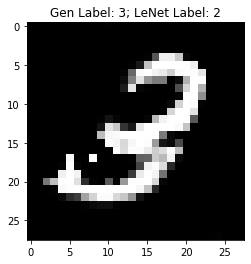

In [167]:
# Plots a sample
sample_idx = 26
print(gen_labels[sample_idx])
plt.imshow(gen_imgs[sample_idx][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
plt.title("Gen Label: " + str(gen_labels.cpu().detach().numpy()[sample_idx]) + "; LeNet Label: " + str(np.argmax(pred_labels.data.cpu().numpy()[sample_idx])))

In [158]:
# Finds target classification for sample
pred_labels = target_classifier(gen_imgs)
np.argmax(pred_labels.data.cpu().numpy()[sample_idx])
#pred_labels.data.cpu().numpy()[sample_idx]

4

In [139]:
# Finds indexes that have adversarial examples
t_acc = np.argmax(pred_labels.data.cpu().numpy(), axis=1) == gen_labels.data.cpu().numpy()
np.where(t_acc == False)

(array([23, 24, 26, 43, 45, 46]),)

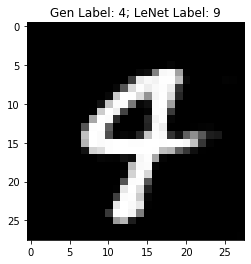

In [175]:
gen = gen_imgs.cpu().detach().numpy()
preds = pred_labels.data.cpu().numpy()
true = gen_labels.data.cpu().numpy()
for i in range(len(true)):
    if np.argmax(preds[i]) != true[i]:
        plt.title("Gen Label: " + str(true[i]) + "; LeNet Label: " + str(np.argmax(preds[i])))
        plt.imshow(gen[i][0], cmap='gray')
        plt.savefig("../images/FirstRun/AdversarialExamples/" + str(i) + ".png")

In [176]:
# Extra saving
torch.save(gen_imgs, "../models/Success1_GenSample")
torch.save(gen_labels, "../models/Success1_GenLabels")
torch.save(pred_labels, "../models/Success1_LeNetLabels")